In [13]:
import numpy as np
import pandas as pd

from eval_utils import *
from model_evaluation import *

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('fraudTrain.csv')

## Препроцессинг

Повторим бейзлайн решение, обучив начальные модели 

In [14]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['day_of_month'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week',
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']


In [15]:
X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(df, numerical_features, categorical_features)
baseline_results = run_experiment(X_train_proc, X_test_proc, y_train, y_test, 
                                 "Бейзлайн")


ЭКСПЕРИМЕНТ: Бейзлайн
Train shape: (1037340, 26), Test shape: (259335, 26)


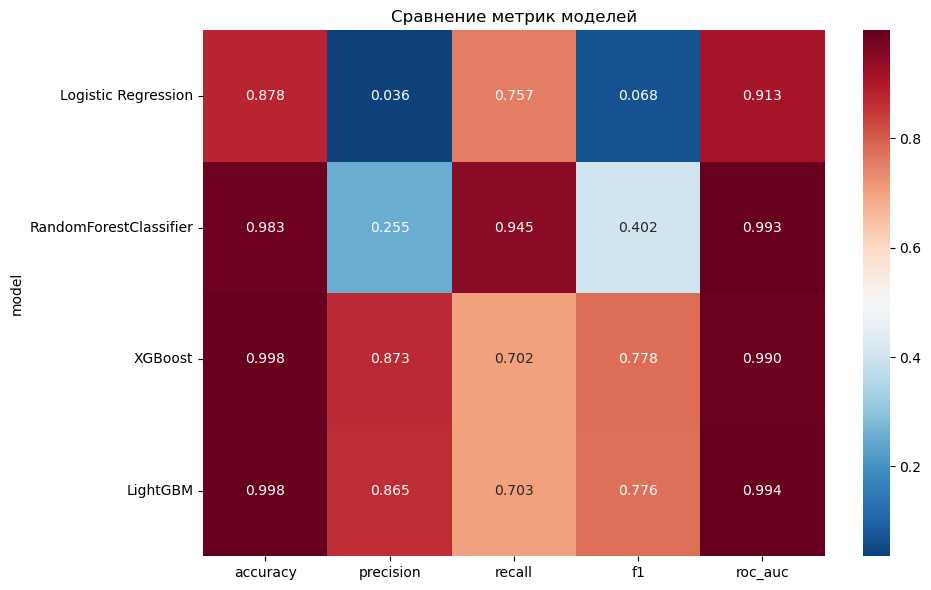

In [16]:
baseline_metrics = compare_models_metrics(baseline_results)

## Feature engineering

Будем использовать итеративный подход, поочередно применять удачные преобразования, сравнивая результат каждого нового преобразования с результатом предыдущего.

**🔒 Принцип предотвращения Data Leakage:**

При расчете всех признаков следим, чтобы **не происходило заглядывания в будущее**:
- ✅ Признаки вычисляются только на основе информации, **доступной на момент транзакции**
- ✅ Агрегации используют только **предыдущие** данные (expanding window, cumsum + shift)
- ✅ Time-based split: train на более ранних данных, test на более поздних
- ❌ Запрещено: группировки по всему датасету, использование будущих транзакций

### Подход №1

- Сколько всего потратил клиент за день (daily_spending)

- Сколько транзакций было за день было у клиента по этой карте (daily_transactions)

Для того чтобы модель в дальнейшем при обучении не заглядывала в будущее, не будем агрегировать весь день целиком. Вместо этого для каждой транзакции используем только предыдущие за этот день.

In [ ]:
def calculate_daily_aggregates(df):
    """
    Добавляет ежедневные суммарные траты и количество транзакций по карте.
    (Для каждой транзакции используются только предыдущие транзакции в этот день)
    """
    df = df.sort_values('trans_date_trans_time').reset_index(drop=True)
    df['trans_date_only'] = df['trans_date_trans_time'].dt.date
    
    # Для каждой транзакции вычисляем кумулятивные траты и количество
    df['daily_spending'] = df.groupby(['cc_num', 'trans_date_only'])['amt'].cumsum()
    df['daily_transactions'] = df.groupby(['cc_num', 'trans_date_only']).cumcount() + 1
    
    # Сдвигаем на 1, чтобы не включать текущую транзакцию
    df['daily_spending_prev'] = df.groupby(['cc_num', 'trans_date_only'])['daily_spending'].shift(1).fillna(0)
    df['daily_transactions_prev'] = df.groupby(['cc_num', 'trans_date_only'])['daily_transactions'].shift(1).fillna(0)
    
    df = df.drop(columns=['trans_date_only', 'daily_spending', 'daily_transactions'])
    
    df = df.rename(columns={
        'daily_spending_prev': 'daily_spending',
        'daily_transactions_prev': 'daily_transactions'
    })
    
    return df


ЭКСПЕРИМЕНТ: Ежедневные траты и количество транзакций
Train shape: (1037340, 28), Test shape: (259335, 28)


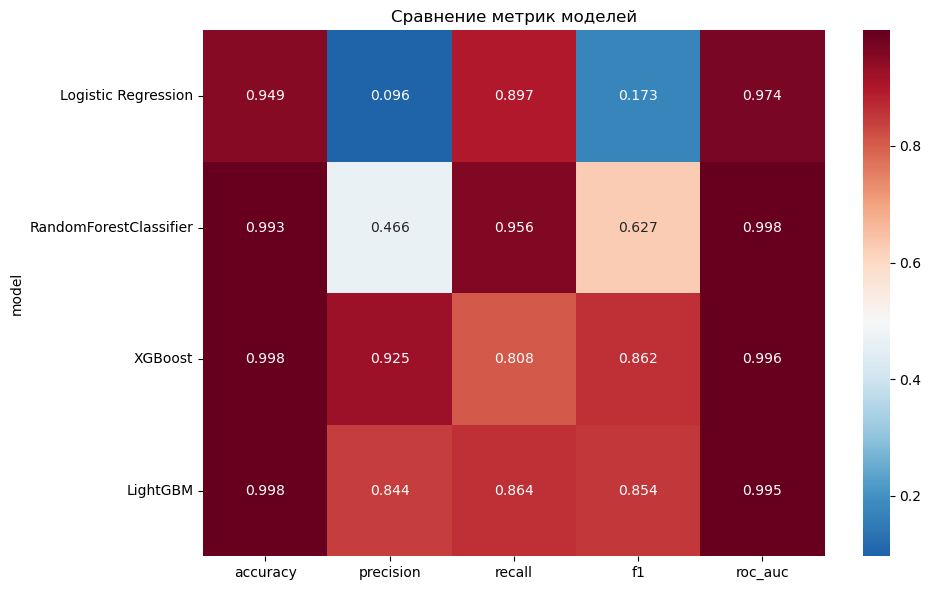

In [18]:
df_exp1 = calculate_daily_aggregates(df)

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week',
        'daily_spending', 'daily_transactions'
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']

X_train_proc1, X_test_proc1, y_train_exp1, y_test_exp1 = get_baseline_preprocessing(df_exp1, numerical_features, categorical_features)
exp1_results = run_experiment(X_train_proc1, X_test_proc1, y_train_exp1, y_test_exp1,
                             "Ежедневные траты и количество транзакций")

# Сравнение с baseline
exp1_metrics = compare_models_metrics(exp1_results)

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.071579,0.060197,0.140442,0.105070,0.060803
RandomForestClassifier,0.009937,0.211067,0.011053,0.225012,0.004400
XGBoost,0.000841,0.051715,0.105332,0.083822,0.006501
LightGBM,0.000656,-0.021683,0.161248,0.078094,0.001255


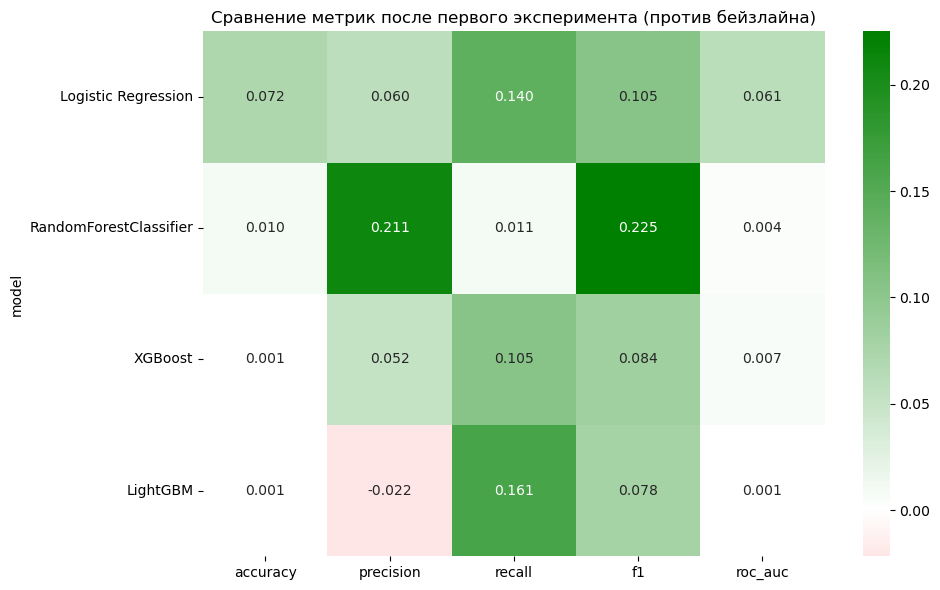

In [19]:
compare_after_add(exp1_metrics, baseline_metrics, 'Сравнение метрик после первого эксперимента (против бейзлайна)')

Получили заметные улучшения для Logistic Regression и RandomForestClassifier и также значительный прирост recall и f1 метрики для моделей бустинга

### Подход №2

Добавим признак, который вычисляет расстояние между между клиентом и продавцом. Таким образом, можно будет определить мошеннеческие транзакции, если между ними условно 5 минут и сотни километров.

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Вычисляет расстояние между объектами учитывая сферическую форму Земли (Haversine formula)"""
    R = 6371  # Earth radius in km
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

def calculate_distance(df):
    """
    Вычисляет расстояние между клиентом и мерчантом.
    ✅ Безопасно от data leakage: использует только координаты текущей транзакции.
    """
    df['distance'] = haversine_distance(
        df['lat'].values, 
        df['long'].values,
        df['merch_lat'].values, 
        df['merch_long'].values
    )
    return df


ЭКСПЕРИМЕНТ: Вычисление расстояния между клиентом и магазином
Train shape: (1037340, 29), Test shape: (259335, 29)


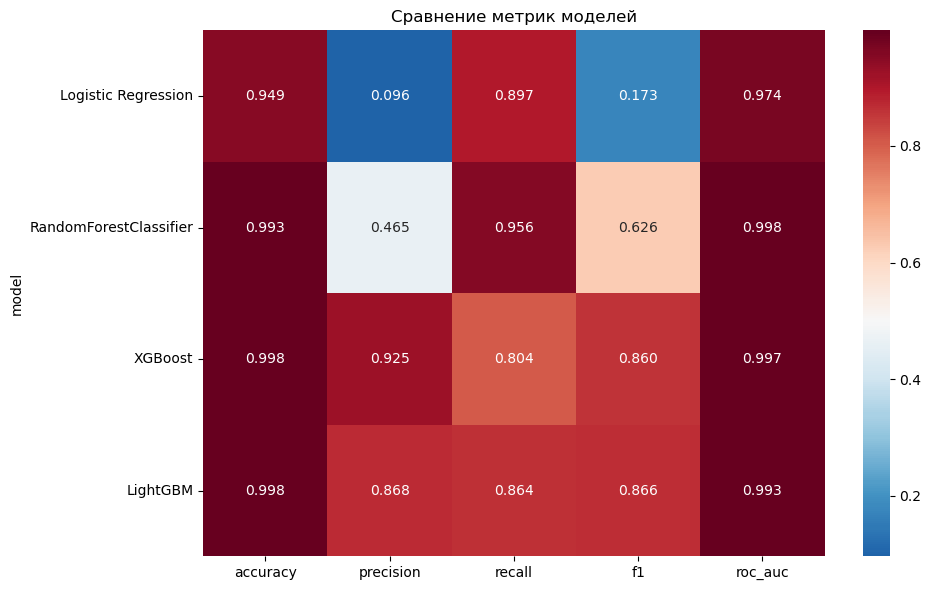

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,-0.000035,-0.000060,0.000000,-0.000098,0.000018
RandomForestClassifier,-0.000019,-0.000760,-0.000650,-0.000826,0.000077
XGBoost,-0.000019,0.000354,-0.003901,-0.002075,0.000505
LightGBM,0.000170,0.024251,0.000000,0.012241,-0.001441


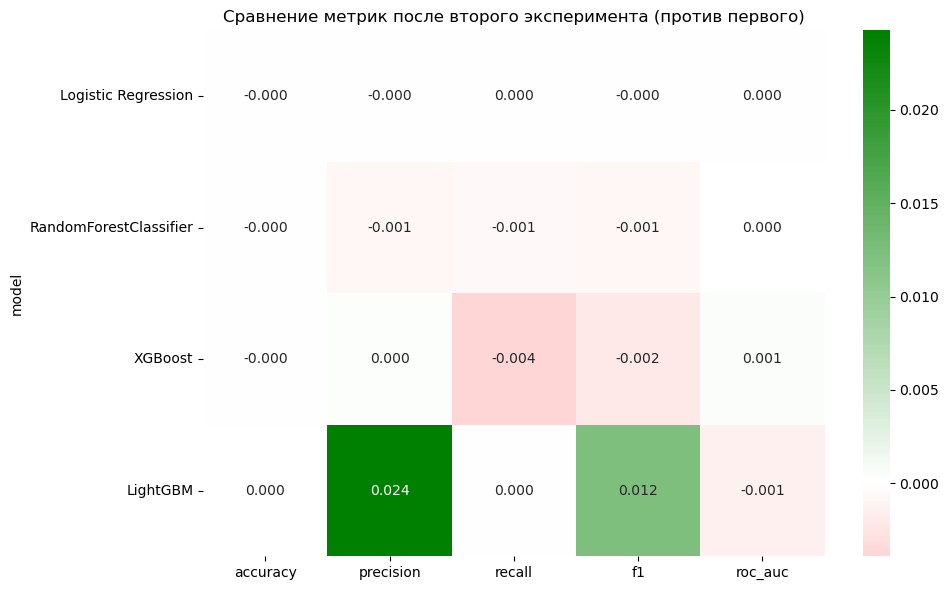

In [21]:
df_exp2 = calculate_distance(df_exp1)

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week', 
        'daily_spending', 'daily_transactions', 'distance'
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']

X_train_proc2, X_test_proc2, y_train_exp2, y_test_exp2 = get_baseline_preprocessing(df_exp2, numerical_features, categorical_features)
exp2_results = run_experiment(X_train_proc2, X_test_proc2, y_train_exp2, y_test_exp2,
                             "Вычисление расстояния между клиентом и магазином")


exp2_metrics = compare_models_metrics(exp2_results)

compare_after_add(exp2_metrics, exp1_metrics, 'Сравнение метрик после второго эксперимента (против первого)')

Немного улучшился бустинг LightGBM. Метрики остальных моделей не изменились

### Подход №3 

Вычислим возраст клиента на момент совершения транзакции (age). Таким образом можем вычислять нетипичных клиентов (в 18 лет совершать люксовые покупки и т.п.)

In [ ]:
def calculate_age(df):
    """
    Вычисление возраста клиента на момент транзакции.
    ✅ Безопасно от data leakage: возраст вычисляется на основе даты рождения
    и времени текущей транзакции (информация доступна на момент транзакции).
    """
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = ((df['trans_date_trans_time'] - df['dob']).dt.days / 365.25).astype(int)
    return df


ЭКСПЕРИМЕНТ: Вычисление возраста клиента
Train shape: (1037340, 30), Test shape: (259335, 30)


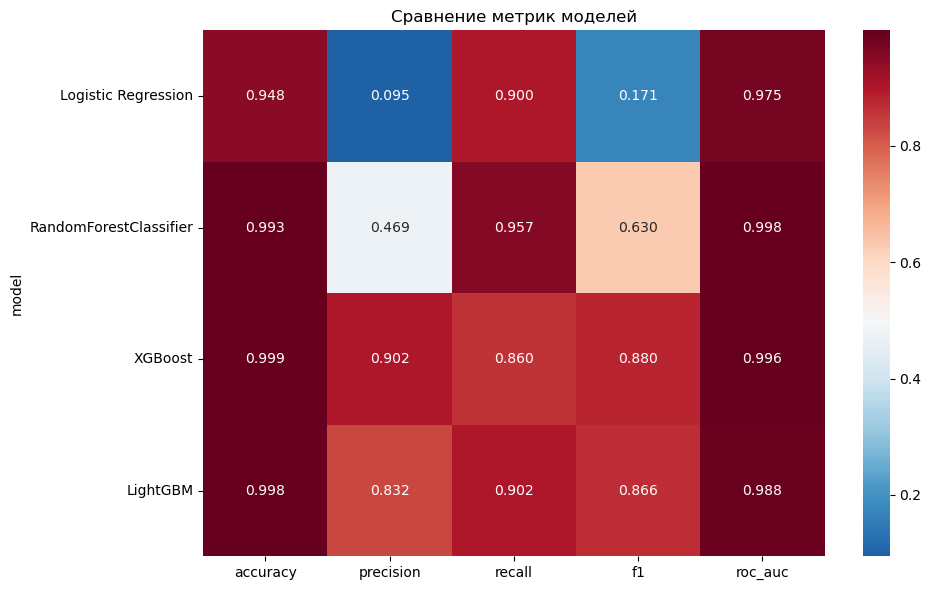

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,-0.000891,-0.001295,0.002601,-0.002069,0.001121
RandomForestClassifier,0.000096,0.003754,0.001300,0.003668,0.000020
XGBoost,0.000162,-0.023376,0.055917,0.020035,-0.000767
LightGBM,-0.000073,-0.035926,0.038362,-0.000204,-0.005102


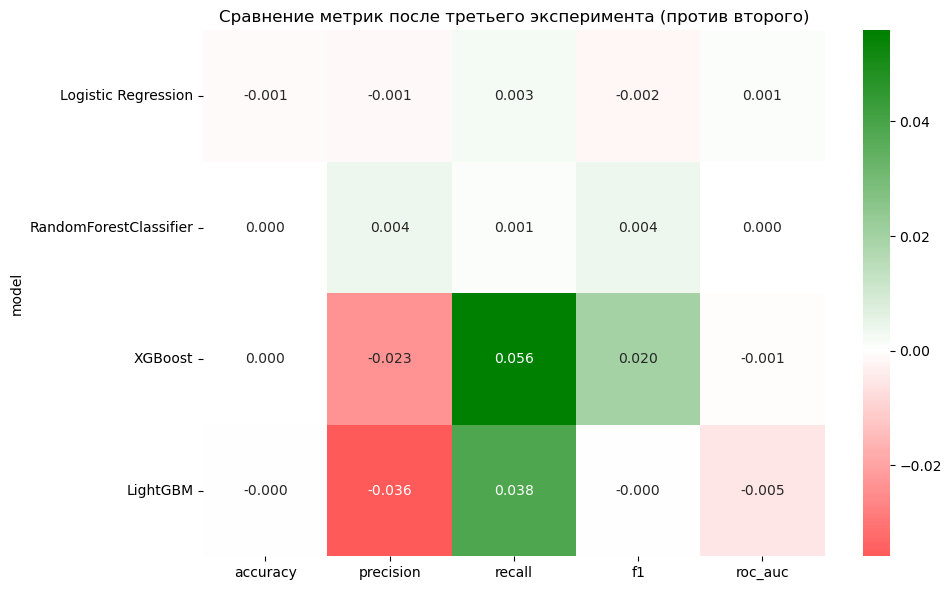

In [23]:
df_exp3 = calculate_age(df_exp2)

numerical_features = [
        'amt', 'lat', 'long', 'city_pop', 
        'merch_lat', 'merch_long', 'hour', 'day_of_week', 
        'daily_spending', 'daily_transactions', 'distance','age'
    ]

categorical_features = ['merchant', 'category', 'gender', 'job']

X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3 = get_baseline_preprocessing(df_exp3, numerical_features, categorical_features)
exp3_results = run_experiment(X_train_proc3, X_test_proc3, y_train_exp3, y_test_exp3,
                                "Вычисление возраста клиента")

exp3_metrics = compare_models_metrics(exp3_results)
compare_after_add(exp3_metrics, exp2_metrics, 'Сравнение метрик после третьего эксперимента (против второго)')


Тут видим, незначительные улучшения precision и f1 метрики для RandomForestClassifier и recall для LightGBM

Итого после всех преобразований, метрики по сравнению с бейзлайном увеличелись следующим образом:

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression,0.070654,0.058842,0.143043,0.102903,0.061942
RandomForestClassifier,0.010014,0.214061,0.011704,0.227853,0.004498
XGBoost,0.000983,0.028694,0.157347,0.101781,0.006240
LightGBM,0.000752,-0.033358,0.199610,0.090132,-0.005287


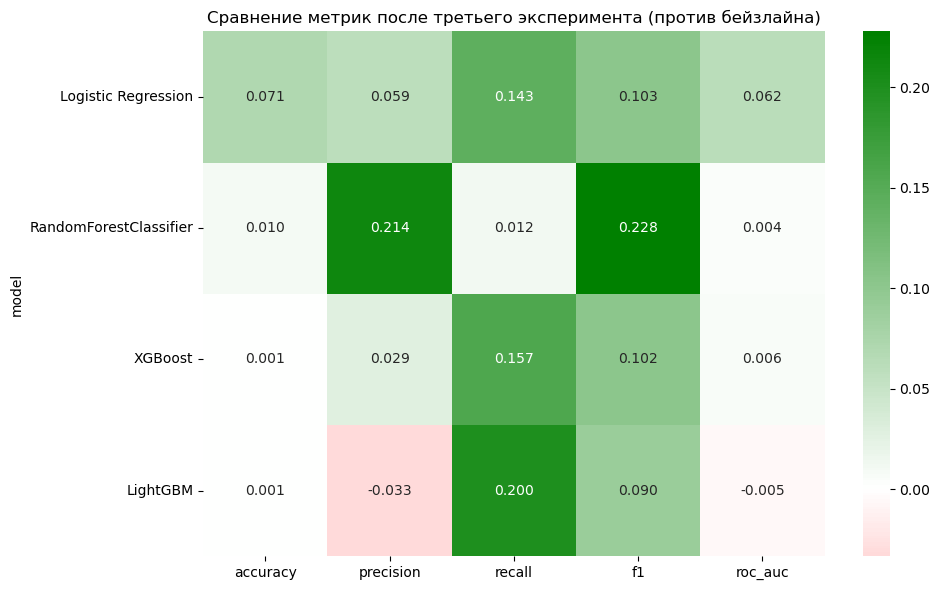

In [24]:
compare_after_add(exp3_metrics, baseline_metrics, 'Сравнение метрик после третьего эксперимента (против бейзлайна)')

LightGBM изначально, на фоне остальных моделей среди бейзлайна была лидером. Теперь получилось увеличить ее recall на 0,2. Далее будем работать с этой моделью и попробуем улучшить ее качество с помощью подбора гиперпараметров

**Вывод**: таким образом, было проведено три эксперимента, в ходе которых добавлены 4 признака. Recall увеличился на 0.2, однако precision почти не изменился. Будем пробовать улучшить метрики путем подбора гиперпараметров.